# Random Forest ile Maaş Sınıflandırma
Bu kod "Dataset salary 2024" veri setini kullanarak çalışanların deneyim seviyelerini tahmin etmek için bir Random Forest sınıflandırma modeli oluşturur.

1. Gerekli kütüphanelerin yüklenmesi.
2. Veri setinin yüklenmesi ve ön işleme (nadir görülen iş unvanlarının filtrelenmesi).
3. Kategorik değişkenlerin kodlanması (One-Hot ve Ordinal Encoding).
4. Verinin eğitim ve test setlerine ayrılması.
5. Random Forest modelinin eğitilmesi.
6. Modelin performansının değerlendirilmesi ve görselleştirilmesi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns

## Veri Yükleme ve Filtreleme
Veri setini yüklüyoruz ve 'job titles' sütunundaki az sayıda bulunan verileri veri setinden çıkarıyoruz. Bu sayede modelin çok nadir görülen sınıflar üzerinde aşırı öğrenmesini engelliyoruz.

In [2]:
#Veriyi import etme
data = pd.read_csv('Dataset salary 2024.csv')
data.dropna()
#Veri kirliliğinin fazla olduğu 'job_title' sütununu filtreleme
threshold = len(data) * 0.02
job_counts = data['job_title'].value_counts()
valid_jobs = job_counts[job_counts >= threshold].index
#Filtrelenmiş veriyi yeni bir dataframe'e kopyalama
data_filtered = data[data['job_title'].isin(valid_jobs)].copy()
#Kontrol için sonucu ekrana yazdırma
print(f"Orijinal veri sayısı: {len(data)}")
print(f"Filtrelenmiş veri sayısı: {len(data_filtered)}")

Orijinal veri sayısı: 16534
Filtrelenmiş veri sayısı: 12755


## Özelliklerin ve Hedef Değişkenin Belirlenmesi
Tahmin etmek istediğimiz hedef sütun 'experience_level'. 
Modeli eğitmek için kullanacağımız özellikler ise şunlardır:
- 'salary_in_usd': Maaş
- 'work_year': Çalışma yılı
- 'employment_type': Çalışma tipi(tam zamanlı, yarı zamanlı vb.)
- 'job_title': İş unvanı
- 'remote_ratio': Uzaktan çalışma oranı
- 'company_size': Şirket büyüklüğü
- 'company_location': Şirket konumu

In [3]:
#Filtrelenmiş verideki target ve feature sütunlarını ayarlama
target = 'experience_level'
features = ['salary_in_usd', 'work_year', 'employment_type', 'job_title', 'remote_ratio', 'company_size', 'company_location']
#Sütunları X ve Y değerlerine atama
X = data_filtered[features]
y = data_filtered[target]

## Ön İşleme (Preprocessing)
Makine öğrenmesi modelleri genellikle sayısal verilerle çalışır. Bu nedenle kategorik verileri dönüştürmemiz gerekir:
- Ordinal Encoding: 'company_size' gibi sıralı bir anlam ifade eden (S < M < L) değişkenler için kullanılır.
- One-Hot Encoding: 'job_title' veya 'company_location' gibi sıralı olmayan nominal değişkenler için kullanılır.

In [4]:
#Sıralı ifadeler
ordinal_cols = ['company_size']
ordinal_cats = [['S', 'M', 'L']]
#Nominal ifadeler
nominal_cols = ['employment_type', 'job_title', 'company_location', 'remote_ratio', 'work_year']
#Ön işleme ile
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ],
    remainder='passthrough'
)

## Model Eğitimi
Veriyi %80 eğitim ve %20 test seti olarak ayırıp Pipeline ile preprocessing adımlarını ve RandomForestClassifier modelini birleştiriyoruz bu sayede veriye dönüşümler otomatik olarak uygulanır.

In [5]:
#Veriyi böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Modeli oluştur(Pipeline içinde)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
#Modeli eğit
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['S',
                                                                              'M',
                                                                              'L']]),
                                                  ['company_size']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['employment_type',
                                                   'job_title',
                                                   'company_location',
                                                   'remote_ratio',
                                                   'work_year'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Model Değerlendirmesi

Modelin başarısını bulmak için accuracy score'u hesaplıyoruz ve modelin hangi sınıfları doğru, hangilerini yanlış tahmin ettiğini görmek için Confusion Matrix çizdiriyoruz.

Doğruluk (Accuracy): 0.7295


<Figure size 1000x800 with 0 Axes>

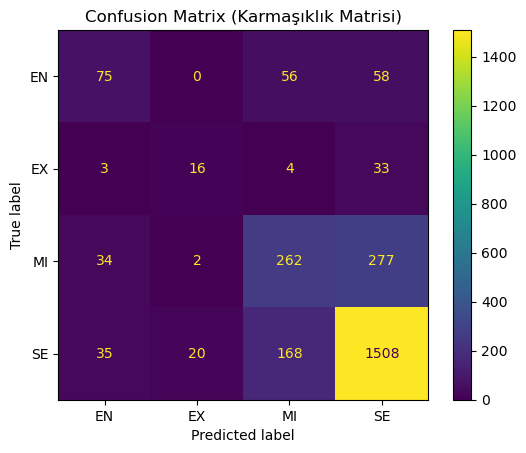

In [6]:
#Accuarcy score'u yazdır
print(f"Doğruluk (Accuracy): {model.score(X_test, y_test):.4f}")

#Matplotlib ile görselleştirme
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix (Karmaşıklık Matrisi)')
plt.show()



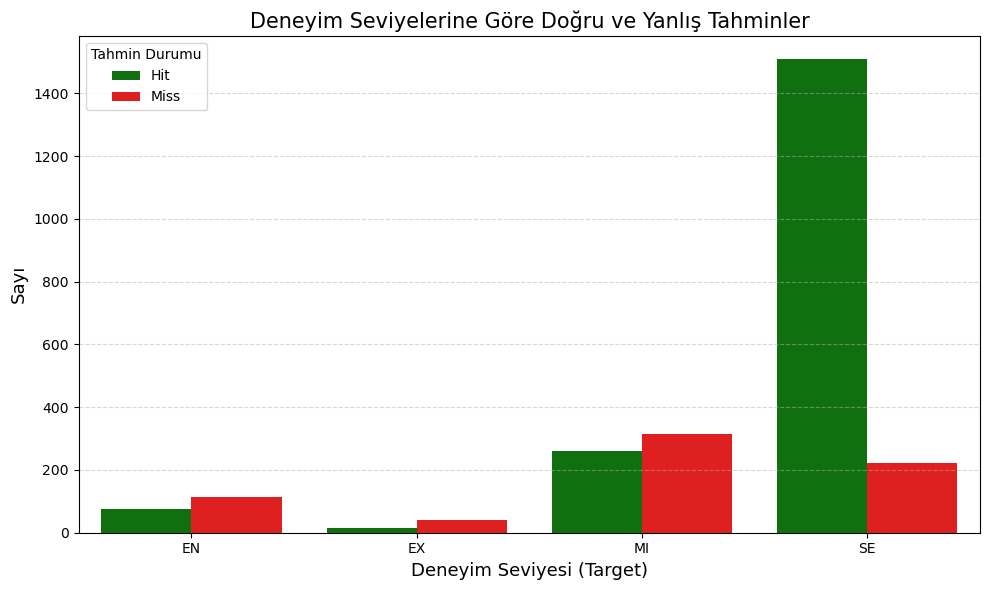

In [7]:
y_pred = model.predict(X_test)
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

#Hit ve Miss sütunlarını ekleme
comparison_df['Outcome'] = comparison_df.apply(
    lambda row: 'Hit' if row['Actual'] == row['Predicted'] else 'Miss', axis=1
)

#Veriyi Hit/Miss olarak gruplama
plot_data = comparison_df.groupby(['Actual', 'Outcome']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))

# Seaborn ile sütun grafiği oluştur
sns.barplot(
    data=plot_data, 
    x='Actual', 
    y='Count', 
    hue='Outcome', 
    palette={'Hit': 'green', 'Miss': 'red'}
)

plt.title('Deneyim Seviyelerine Göre Doğru ve Yanlış Tahminler', fontsize=15)
plt.xlabel('Deneyim Seviyesi (Target)', fontsize=13)
plt.ylabel('Sayı', fontsize=13)
plt.legend(title='Tahmin Durumu')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## SONUÇ

Bütün işlemeler sonucunda oluşturulan modelimiz %70 civarında bir başarı oranı ile 'experience_level' sütununu tahmin ediyor. Başarı oranının bu seviyede olmasının sebebi ise görsellerden de anlaşılabileceği gibi veri setimizde 'experience_level' sütunundaki 'EN','EX' ve 'MI' değerlerinin az sayıda bulunmasıdır. Yeterince veri bulunan 'SE' değeri için alınan sonuçların başarı oranı model başarısından daha yüksektir. 'experience_level' sütununu tahmin etmek için en önemli özellik 'salary_in_usd' sütunudur, bu ikisi yüksek oranda korelasyon gösterir. 'employment_type' sütunuyla ise düşük oranda korelasyon gösterir